In [32]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS No_Crimes, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)

In [117]:
# Get rid of the redundant decimal places 
crime_type.No_Crimes = crime_type.No_Crimes.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 

In [118]:
# Get socioeconomics data 
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)
# crime_type.head(15)

In [37]:
crime_df = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')

In [39]:
# geopandas starts from here

import matplotlib.pyplot as plt
import geopandas as gpd

In [119]:
chicomm_df = gpd.read_file("data/chicomm/chicomm.shp")
chicomm_df.rename(columns = {'CHICOMNO':'Community Area Number'}, inplace = True)
chicomm_df.set_index('Community Area Number', inplace = True)
chicomm_df.index = chicomm_df.index.astype(int)
chicomm_df.sort_index(inplace = True)

In [43]:
# chicomm_df_4plot = chicomm_df.copy()

In [122]:
# plotting crimes total
crime_sum = crime_df.groupby('Community Area Number').sum()
crime_sum.index = crime_sum.index.astype(int)
crime_sum_geo = chicomm_df.join(crime_sum)

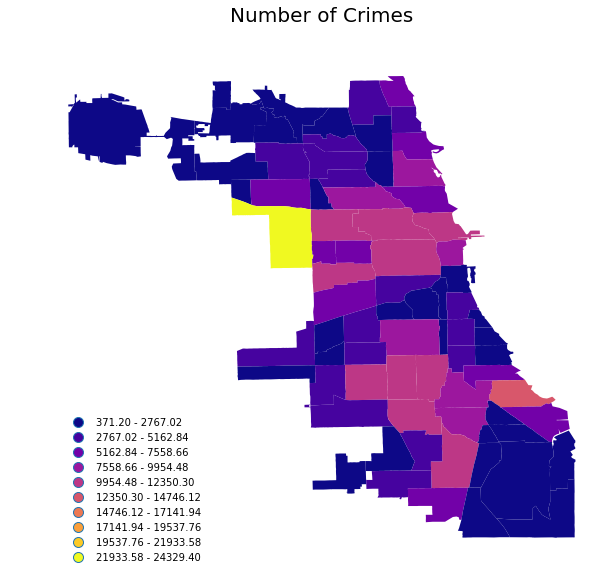

In [123]:
ax_sum = crime_sum_geo.plot(column = 'No_Crimes', cmap = 'plasma', scheme = 'equal_interval',
                            k = 10, linewidth = 2,
                            legend = True, figsize = (10, 10),
                            )
ax_sum.set_title("Number of Crimes", fontsize = 20, y = 1.05)
ax_sum.get_legend().set_bbox_to_anchor((0.3, 0.3))
ax_sum.get_legend().get_frame().set_linewidth(0)
ax_sum.set_axis_off()
# ax_sum.figure.savefig('output/maps/Number_of_Crimes.png')

/home/bac2qh/anaconda3/envs/py-geo/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/home/bac2qh/anaconda3/envs/py-geo/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/home/bac2qh/anaconda3/envs/py-geo/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


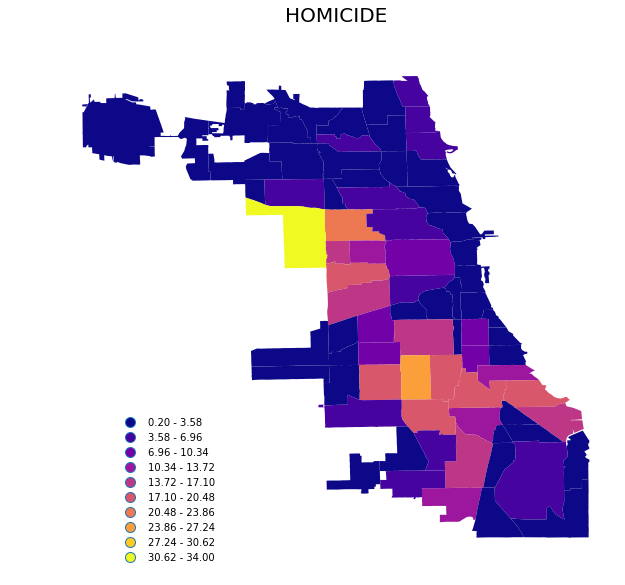

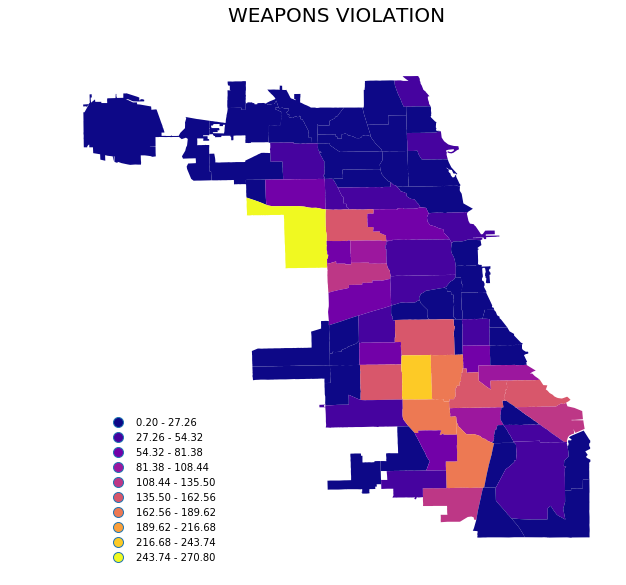

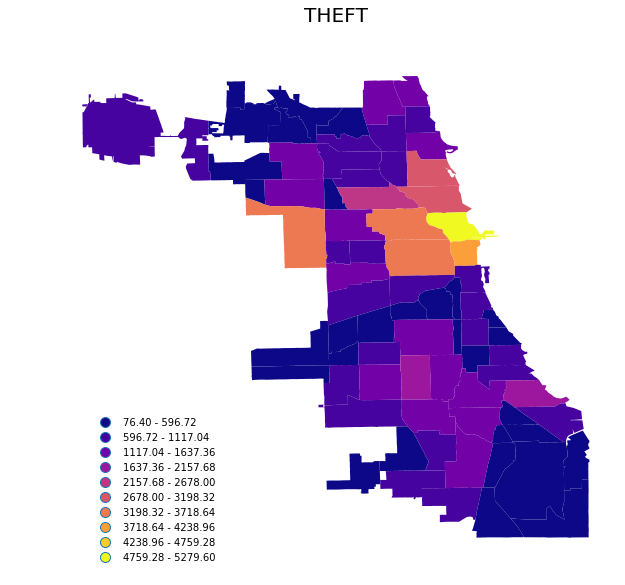

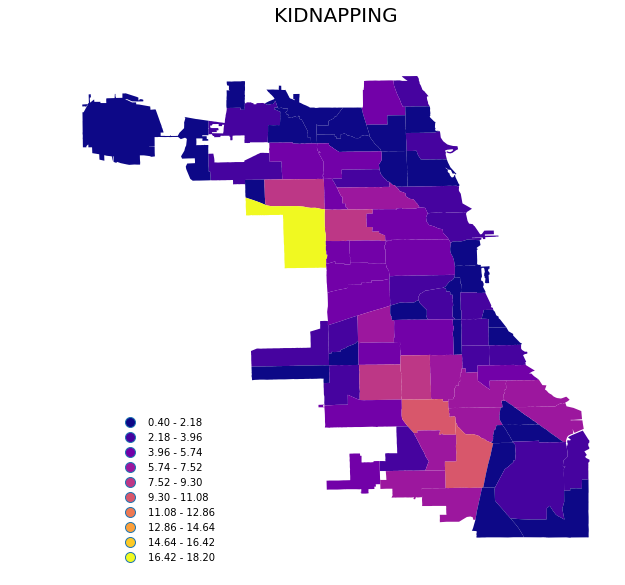

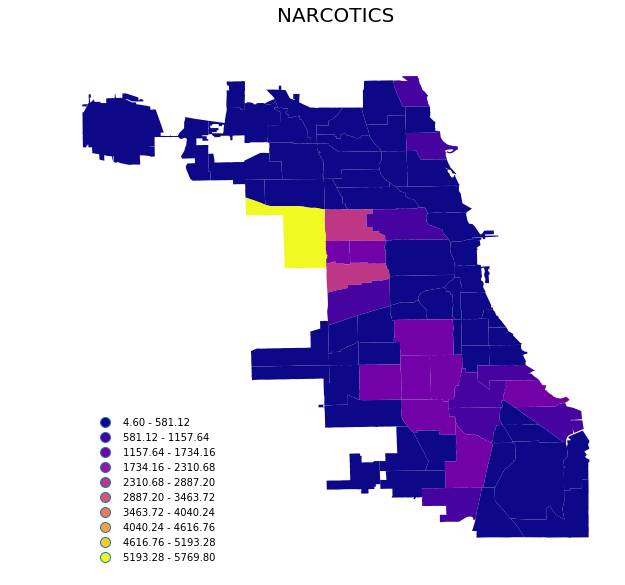

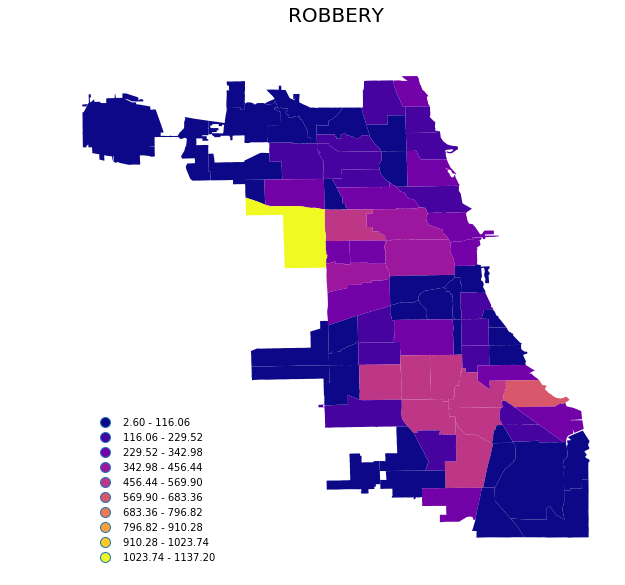

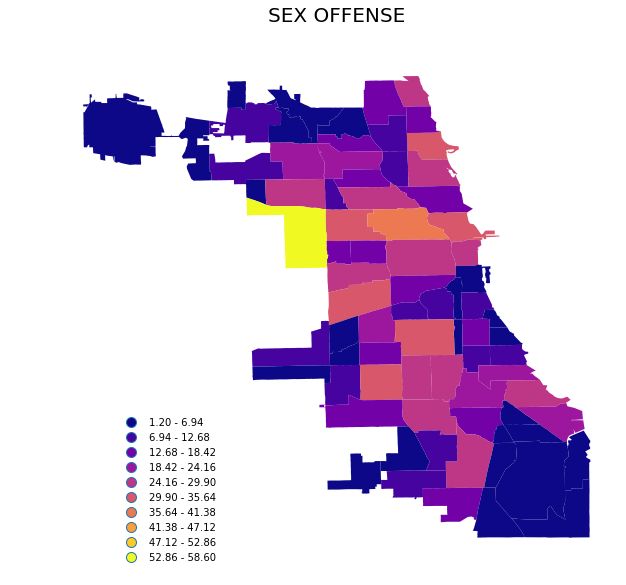

In [116]:
# for primary_types
crime_list = ['HOMICIDE', 'WEAPONS VIOLATION', 'THEFT', 'KIDNAPPING', 'NARCOTICS', 'ROBBERY', 'SEX OFFENSE']
crime_fname = [str(v).lower().replace(' ', '_') for v in crime_list]
counter = 0
for entry in crime_list:
    crime_x = crime_df[crime_df.Primary_Type == crime_list[counter]]
    crime_x.set_index('Community Area Number', inplace = True)
    crime_x = crime_x.sort_index()
    
    crime_x_geo = chicomm_df.join(crime_x)
    ax = crime_x_geo.plot(column = "No_Crimes", cmap = 'plasma', scheme = 'equal_interval',
                            k = 10, linewidth = 2,
                            legend = True, figsize = (10, 10))
    
    ax.set_title("{}".format(crime_list[counter]), fontsize = 20, y = 1.05)
    ax.get_legend().set_bbox_to_anchor((0.3, 0.3))
    ax.get_legend().get_frame().set_linewidth(0)
    ax.set_axis_off()
    ax.set_ylabel(crime_fname[counter])
#     ax.figure.savefig('output/maps/{}.png'.format(crime_fname[counter]))
    
    counter += 1

In [126]:
# building interactive map
import folium

m = folium.Map([41.8, -87.8], 
               tiles='cartodbpositron', 
               zoom_start=9.3, max_zoom=17, min_zoom=4)


colormap = folium.LinearColormap(("red", "orange", "yellow", "green",
                                  "blue", "purple"), 
                                 vmin = crime_sum_geo['No_Crimes'].min(), 
                                 vmax = crime_sum_geo['No_Crimes'].max(),
                                 caption = 'Number of Crimes')

colormap.add_to(m)

folium.GeoJson(crime_sum_geo,
               style_function = lambda feature: { 
                  'fillColor': colormap(feature['properties']['No_Crimes']),
                  "color" : "black", "weight" : 1, "fillOpacity" : 0.55
               }).add_to(m)

m.save("output/maps/Number_of_Crimes.html")

m

In [124]:
# # create maps for different primary_type
# from shapely.geometry import Point

# # query BURGLARY's location
# soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
# soql += quote("SELECT community_area, primary_type, latitude, longitude ")
# # soql += quote("latitude, longtitude ")
# soql += quote("WHERE 2007 < year AND year < 2013 AND primary_type = 'BURGLARY' ")
# soql += quote("LIMIT 200000 ")

# resp = requests.get(soql).json()

# crime_type_burglary = pd.DataFrame(resp)
# crime_type_burglary = crime_type_burglary.dropna()
# crime_type_burglary.longitude = crime_type_burglary.longitude.astype(float)
# crime_type_burglary.latitude = crime_type_burglary.latitude.astype(float)
# geometry = [Point(xy) for xy in zip(crime_type_burglary.longitude, crime_type_burglary.latitude)]
# crime_coords_burglary = gpd.GeoDataFrame(crime_type_burglary,
#                                 crs = {'init': 'epsg:4269'}, geometry=geometry)

# # remove irrelevant points
# crime_coords_burglary = crime_coords_burglary[crime_coords_burglary.latitude > 40]

# crime_coords_burglary.plot(markersize = 0.01)

# located_bulglary = gpd.sjoin(crime_coords_burglary, chicomm_df_4plot, how = 'left', op = 'within')

# burglary_chicomm_count = located_bulglary.groupby("community_area").count()
# burglary_chicomm_count = burglary_chicomm_count[["index_right"]].rename(columns = {"index_right" : "BURGLARY"})
# burglary_chicomm_count.index = burglary_chicomm_count.index.astype(int)
# chicomm_df_4plot.rename(columns = {'DISTNAME':'community_area'}, inplace = True)

# mapped_burglary = pd.merge(chicomm_df_4plot, burglary_chicomm_count, how = "inner", left_on = "community_area", right_index = True)

# mapped_burglary.plot(column = "BURGLARY", cmap = "plasma", k = 9, linewidth = 0,
#                     figsize = (10, 10) )

In [125]:
# crime_bulglary = crime_df[crime_df['Primary_Type'] == 'BURGLARY']
# crime_bulglary.set_index('Community Area Number', inplace = True)
# crime_bulglary = crime_bulglary.sort_index()

# crime_bulglary_geo = chicomm_df.join(crime_bulglary)
# crime_bulglary_geo.head()
# crime_bulglary_geo = chicomm_df.join(crime_bulglary)
# # crime_bulglary_geo.head()
# crime_bulglary_geo.plot(column = 'No_Crimes')